In [135]:
from collections import namedtuple

import gizeh
import numpy as np

In [136]:
def get_neighbour_concentration(angle, concentration):
    return concentration * abs(np.pi - angle) / (2*np.pi)

In [189]:
class Cell:
    MAX_CONCENTRATION = 1024
    
    def __init__(self, x, y, radius, is_stem=False, stem_angle=None):
        self.x = x
        self.y = y
        self.radius = radius
        self.is_stem = is_stem
        self.neighbours = {}
        self.checked = False
        self.gradient = {x:None,
                         y:None}
        
        if self.is_stem:
            self.stem_angle = stem_angle
            
        if self.is_stem:
            self.concentration = Cell.MAX_CONCENTRATION
        else:
            self.concentration = None
            
    def __repr__(self):
        return '(x: {x}, y: {y}), {c} {stem}'.format(x = self.x,
                                                     y = self.y,
                                                     c = self.concentration,
                                                     stem = '*' if self.is_stem else '')
            
    def set_gradient(self):
        self.checked = True
        if self.is_stem:
            self.concentration += Cell.MAX_CONCENTRATION
            
            stem_angle = (self.stem_angle + np.pi) % (2*np.pi)
            self.gradient['x'] += self.concentration * np.cos(stem_angle)
            self.gradient['y'] += self.concentration * np.sin(stem_angle)
            
        for neighbour, angle in self.neighbours.items():
            angle_to_gradient = self.gradient_angle() - angle
            
            influence = get_neighbour_concentration(angle_to_gradient, self.concentration)
            
            if not neighbour.checked:
                neighbour.concentration += influence
                neighbour.gradient['x'] += self.gradient['x']
                neighbour.gradient['y'] += self.gradient['y']            
                neighbour.set_gradient()
        
        
    def add_neighbour(self, angle, neighbour):
        self.neighbours[neighbour] = angle
        neighbour.neighbours[self] = (np.pi + angle) % np.pi
        
    def gradient_angle(self):
        return np.arctan(self.gradient['y'] / self.gradient['x'])
        
    def divide(self):
        """Return a new neighbour of the cell in the direction of the gradient"""
        return Cell(None, None, self.radius), self.gradient_angle() # x and y don't matter now

In [190]:
class Organism:
    def __init__(self):
        self.cells = [Cell(x=0, y=0, radius=30, is_stem=True, stem_angle=-np.pi/2)]
        self.root_cell = self.cells[0]
        
    def reset_checks(self):
        """Set `cell.checked` attribute of each cell to False"""
        for cell in self.cells:
            cell.checked = False
        
    def set_gradients(self):
        """Set all the gradients and concentrations for `self.cells`"""        
        stem_cells = []
        
        for cell in self.cells:
            cell.concentration = 0
            cell.gradient = {'x': 0,
                             'y': 0}
            if cell.is_stem:
                stem_cells.append(cell)
        
        for cell in stem_cells:
            self.reset_checks()
            cell.set_gradient()
        
    
    def draw(self):
        """Draw the organism"""
        surface = gizeh.Surface(width=500, height=500)
        
        offset = 250
        
        for cell in self.cells:
            circle = gizeh.circle(r=cell.radius,
                                  xy=[cell.x + offset, cell.y + offset],
                                  fill=(cell.concentration/Cell.MAX_CONCENTRATION, 0, 0),
                                  stroke=(0,0,0),
                                  stroke_width=2)
            circle.draw(surface)
            
            # draw the gradient of the cell as an arrow
            triangle = gizeh.regular_polygon(r=cell.radius/5, n=3, angle=0,
                                             xy=[cell.x+offset+.7*cell.radius*cell.concentration/Cell.MAX_CONCENTRATION,
                                                 cell.y+offset], fill=(1,1,1))
            
            line = gizeh.polyline(points=[(cell.x+offset, cell.y+offset),
                                          (cell.x+offset+.7*cell.radius*cell.concentration/Cell.MAX_CONCENTRATION,
                                           cell.y+offset)],
                                           stroke_width=3, stroke=(1,1,1))
            
            arrow = gizeh.Group([triangle, line])
            arrow = arrow.rotate(cell.gradient_angle(), center=[cell.x+offset,cell.y+offset])
            arrow.draw(surface)
            
            if cell.is_stem:
                stem_r = cell.radius / 5
                
                circle = gizeh.circle(r=stem_r,
                                      xy=[
                                          cell.x + offset + (cell.radius - stem_r)*np.cos(cell.stem_angle),
                                          cell.y + offset + (cell.radius - stem_r)*np.sin(cell.stem_angle),
                                      ],
                                      fill=(0,0,1))
                circle.draw(surface)
                
            
        return surface
    
    def divide_cells(self):
        
        new_cells = []
        
        for cell in self.cells:
            new_cell, angle = cell.divide()
            cell.add_neighbour(angle, new_cell)
            new_cells.append(new_cell)
            cell.checked = False  # Reset all checks for checking correctness later
        
        for new_cell in new_cells:
            self.cells.append(new_cell)
            
        self._check_correctness(self.root_cell)
        self.set_gradients()
        
        
    def _check_correctness(self, cell):
        """Set correct coordinates to all the cells"""
        cell.checked = True
        
        for neighbour, angle in cell.neighbours.items():
            if not neighbour.checked:
                neighbour.x = cell.x + 2*cell.radius*np.cos(angle)
                neighbour.y = cell.y + 2*cell.radius*np.sin(angle)
                self._check_correctness(neighbour)

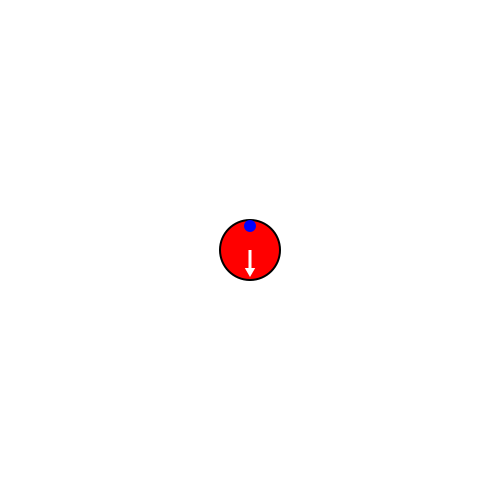

In [191]:
wormy = Organism()
wormy.set_gradients()
wormy.draw()

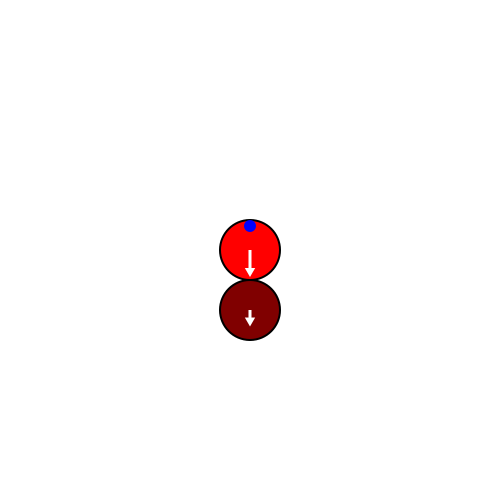

In [192]:
wormy.set_gradients()
wormy.divide_cells()
wormy.draw()

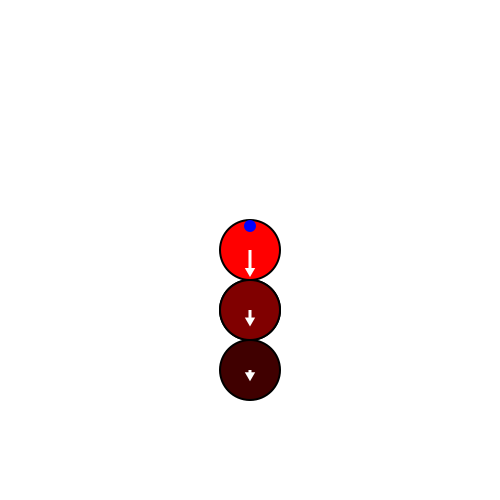

In [193]:
wormy.divide_cells()
wormy.draw()

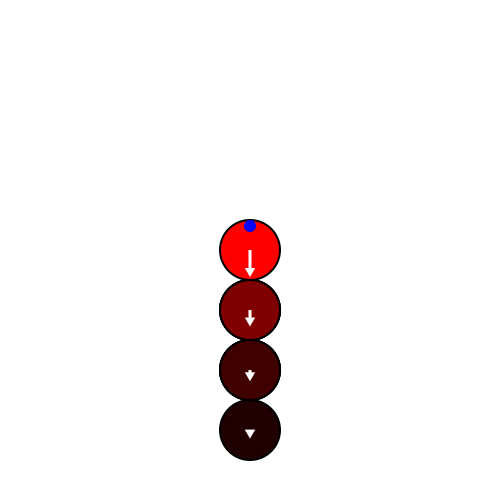

In [194]:
wormy.divide_cells()
wormy.draw()

In [195]:
for cell in wormy.cells:
    print(cell)
    print('-'*20)

(x: 0, y: 0), 1024 *
--------------------
(x: 3.67394039744206e-15, y: 60.0), 512.0 
--------------------
(x: 3.67394039744206e-15, y: 60.0), 512.0 
--------------------
(x: 7.34788079488412e-15, y: 120.0), 256.0 
--------------------
(x: 3.67394039744206e-15, y: 60.0), 512.0 
--------------------
(x: 7.34788079488412e-15, y: 120.0), 256.0 
--------------------
(x: 7.34788079488412e-15, y: 120.0), 256.0 
--------------------
(x: 1.1021821192326179e-14, y: 180.0), 128.0 
--------------------
